# Student Performance Prediction with Neural Networks

This notebook demonstrates:
- **Regression**: Predict final grade (G3)
- **Classification**: Predict Pass/Fail

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load Dataset

In [2]:
DATA_PATH = "../datasets/student_performance/student-mat.csv"

df = pd.read_csv(DATA_PATH, sep=';')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [4]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [5]:
df['G3'].describe()

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

## 3. Exploratory Data Analysis

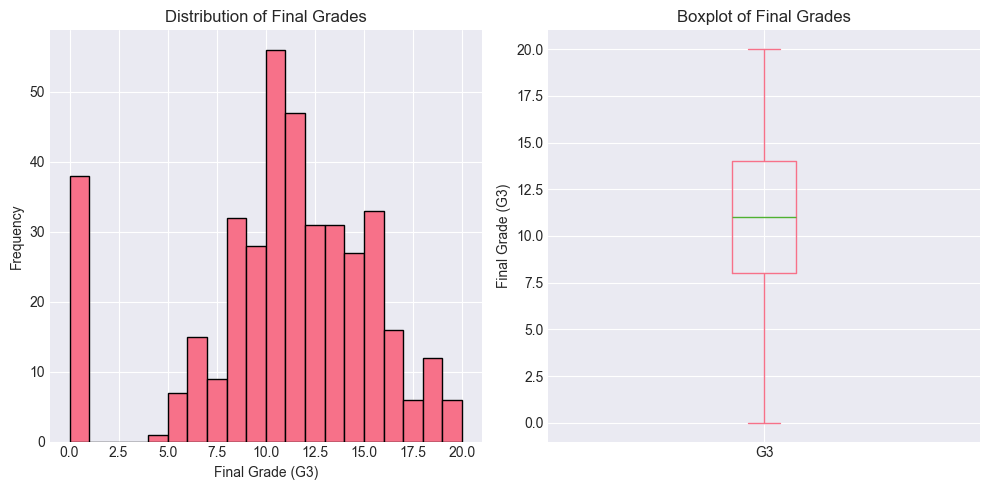

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df['G3'], bins=20, edgecolor='black')
plt.xlabel('Final Grade (G3)')
plt.ylabel('Frequency')
plt.title('Distribution of Final Grades')

plt.subplot(1, 2, 2)
df['G3'].plot(kind='box')
plt.ylabel('Final Grade (G3)')
plt.title('Boxplot of Final Grades')

plt.tight_layout()
plt.show()

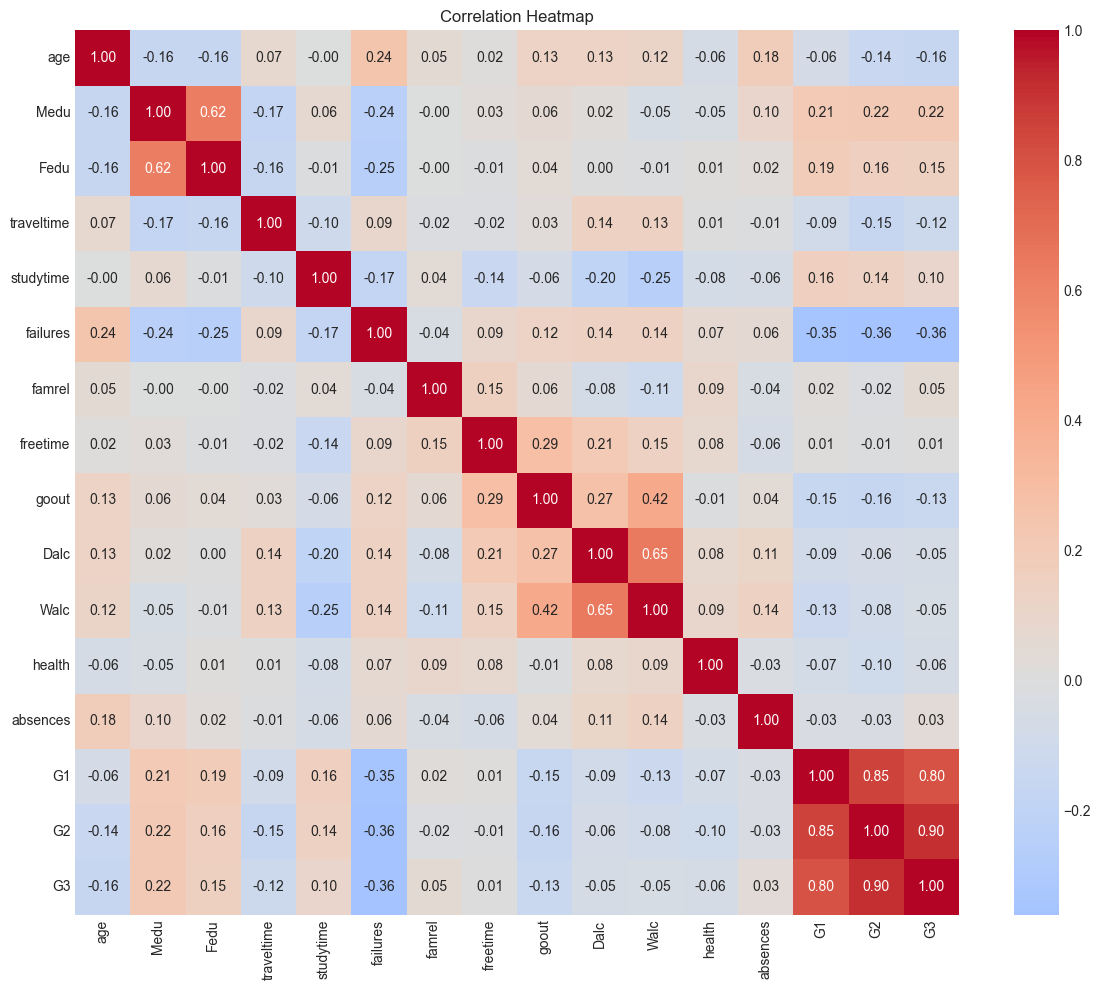

In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

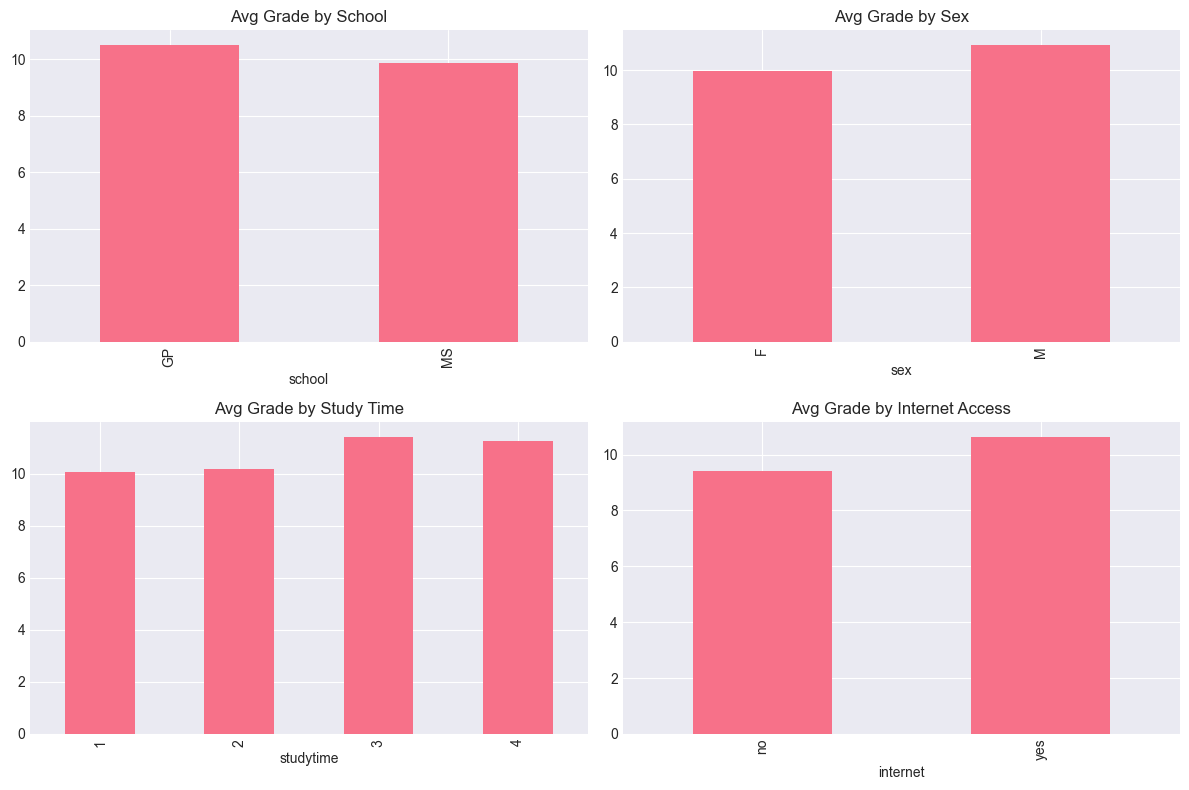

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df.groupby('school')['G3'].mean().plot(kind='bar', ax=axes[0, 0], title='Avg Grade by School')
df.groupby('sex')['G3'].mean().plot(kind='bar', ax=axes[0, 1], title='Avg Grade by Sex')
df.groupby('studytime')['G3'].mean().plot(kind='bar', ax=axes[1, 0], title='Avg Grade by Study Time')
df.groupby('internet')['G3'].mean().plot(kind='bar', ax=axes[1, 1], title='Avg Grade by Internet Access')

plt.tight_layout()
plt.show()

## 4. Define Tasks

In [9]:
df['pass'] = (df['G3'] >= 10).astype(int)

print(f"Pass rate: {df['pass'].mean():.2%}")
print(f"\nClass distribution:")
print(df['pass'].value_counts())

Pass rate: 67.09%

Class distribution:
pass
1    265
0    130
Name: count, dtype: int64


## 5. Feature Selection & Preprocessing

In [10]:
feature_cols = [col for col in df.columns if col not in ['G3', 'pass']]

numeric_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 
                    'failures', 'famrel', 'freetime', 'goout', 'Dalc', 
                    'Walc', 'health', 'absences', 'G1', 'G2']

categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus',
                       'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup',
                       'famsup', 'paid', 'activities', 'nursery', 'higher',
                       'internet', 'romantic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numeric features: 15
Categorical features: 17


In [11]:
X = df[feature_cols]
y_reg = df['G3'].values
y_clf = df['pass'].values

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

input_dim = X_train_transformed.shape[1]
print(f"\nTraining samples: {X_train_transformed.shape[0]}")
print(f"Test samples: {X_test_transformed.shape[0]}")
print(f"Feature dimensions after preprocessing: {input_dim}")


Training samples: 316
Test samples: 79
Feature dimensions after preprocessing: 58


## 6. Regression Model - Predict Final Grade

In [12]:
X_train_transformed.shape

(316, 58)

In [13]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_reg = RegressionModel(input_dim).to(device) #
print(model_reg)

RegressionModel(
  (fc1): Linear(in_features=58, out_features=64, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


loss = error
epoch = ?


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=15):
    history = {'train_loss': [], 'val_loss': [], 'train_metric': [], 'val_metric': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch) # error
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_metric += torch.abs(outputs.squeeze() - y_batch).sum().item()
        
        model.eval()
        val_loss = 0
        val_metric = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item()
                val_metric += torch.abs(outputs.squeeze() - y_batch).sum().item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_metric /= len(train_loader.dataset)
        val_metric /= len(val_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metric'].append(train_metric)
        history['val_metric'].append(val_metric)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
    
    return history

In [15]:
X_train_reg_split, X_val_reg, y_train_reg_split, y_val_reg = train_test_split(
    X_train_transformed, y_reg_train, test_size=0.2, random_state=42
)

X_train_reg_tensor = torch.FloatTensor(X_train_reg_split)
y_train_reg_tensor = torch.FloatTensor(y_train_reg_split)
X_val_reg_tensor = torch.FloatTensor(X_val_reg)
y_val_reg_tensor = torch.FloatTensor(y_val_reg)

train_dataset_reg = TensorDataset(X_train_reg_tensor, y_train_reg_tensor)
val_dataset_reg = TensorDataset(X_val_reg_tensor, y_val_reg_tensor)

train_loader_reg = DataLoader(train_dataset_reg, batch_size=32, shuffle=True)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=32, shuffle=False)

criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)

history_reg = train_model(model_reg, train_loader_reg, val_loader_reg, 
                         criterion_reg, optimizer_reg, epochs=100, patience=15)

Epoch [10/100], Train Loss: 14.2078, Val Loss: 7.7503
Epoch [20/100], Train Loss: 7.3017, Val Loss: 4.4687
Epoch [30/100], Train Loss: 6.3251, Val Loss: 3.6113
Epoch [40/100], Train Loss: 5.3236, Val Loss: 2.9927
Epoch [50/100], Train Loss: 4.9862, Val Loss: 2.9428
Epoch [60/100], Train Loss: 4.5080, Val Loss: 2.4636
Epoch [70/100], Train Loss: 4.0345, Val Loss: 2.2995
Epoch [80/100], Train Loss: 3.6120, Val Loss: 1.8503
Epoch [90/100], Train Loss: 3.2823, Val Loss: 1.7739
Epoch [100/100], Train Loss: 2.7310, Val Loss: 1.7787


In [16]:
print(model_reg.parameters())

<generator object Module.parameters at 0x7f578ce87060>


In [17]:
model_reg.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_transformed).to(device)
    y_pred_reg = model_reg(X_test_tensor).cpu().numpy().flatten()

mse = mean_squared_error(y_reg_test, y_pred_reg)
mae = mean_absolute_error(y_reg_test, y_pred_reg)
r2 = r2_score(y_reg_test, y_pred_reg)

print(f"\nRegression Results:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Regression Results:
MSE: 6.9632
MAE: 1.7696
R²: 0.6604


In [18]:
total_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 6401


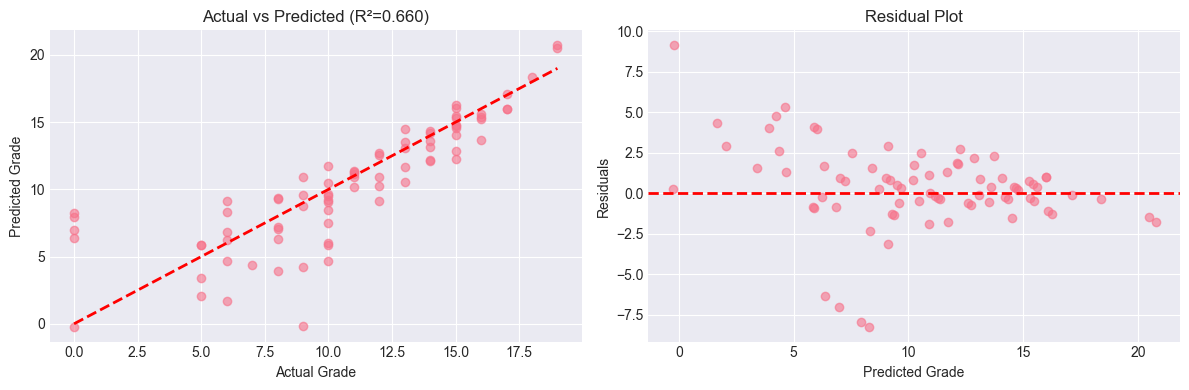

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_reg_test, y_pred_reg, alpha=0.6)
plt.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual Grade')
plt.ylabel('Predicted Grade')
plt.title(f'Actual vs Predicted (R²={r2:.3f})')

plt.subplot(1, 2, 2)
residuals = y_reg_test - y_pred_reg
plt.scatter(y_pred_reg, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Grade')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

## 7. Classification Model - Predict Pass/Fail

In [20]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

model_clf = ClassificationModel(input_dim).to(device)
print(model_clf)

ClassificationModel(
  (fc1): Linear(in_features=58, out_features=64, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [21]:
def train_classifier(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=15):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predictions = (outputs.squeeze() >= 0.5).float()
            train_correct += (predictions == y_batch).sum().item()
        
        model.eval()
        val_loss = 0
        val_correct = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item()
                predictions = (outputs.squeeze() >= 0.5).float()
                val_correct += (predictions == y_batch).sum().item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
    
    return history

In [22]:
X_train_clf_split, X_val_clf, y_train_clf_split, y_val_clf = train_test_split(
    X_train_transformed, y_clf_train, test_size=0.2, random_state=42
)

X_train_clf_tensor = torch.FloatTensor(X_train_clf_split)
y_train_clf_tensor = torch.FloatTensor(y_train_clf_split)
X_val_clf_tensor = torch.FloatTensor(X_val_clf)
y_val_clf_tensor = torch.FloatTensor(y_val_clf)

train_dataset_clf = TensorDataset(X_train_clf_tensor, y_train_clf_tensor)
val_dataset_clf = TensorDataset(X_val_clf_tensor, y_val_clf_tensor)

train_loader_clf = DataLoader(train_dataset_clf, batch_size=32, shuffle=True)
val_loader_clf = DataLoader(val_dataset_clf, batch_size=32, shuffle=False)

criterion_clf = nn.BCELoss()
optimizer_clf = optim.Adam(model_clf.parameters(), lr=0.001)

history_clf = train_classifier(model_clf, train_loader_clf, val_loader_clf, 
                              criterion_clf, optimizer_clf, epochs=100, patience=15)

Epoch [10/100], Train Loss: 0.4343, Val Loss: 0.5516, Val Acc: 0.5625
Epoch [20/100], Train Loss: 0.1746, Val Loss: 0.3445, Val Acc: 0.8281
Epoch [30/100], Train Loss: 0.0876, Val Loss: 0.4018, Val Acc: 0.8438
Epoch [40/100], Train Loss: 0.0519, Val Loss: 0.3535, Val Acc: 0.8906
Epoch [50/100], Train Loss: 0.0200, Val Loss: 0.4149, Val Acc: 0.8750
Early stopping at epoch 51


In [23]:
model_clf.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_transformed).to(device)
    y_pred_clf_proba = model_clf(X_test_tensor).cpu().numpy().flatten()
    y_pred_clf = (y_pred_clf_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_clf_test, y_pred_clf)
print(f"\nClassification Accuracy: {accuracy:.4f}")
print(f"\n{classification_report(y_clf_test, y_pred_clf, target_names=['Fail', 'Pass'])}")


Classification Accuracy: 0.8481

              precision    recall  f1-score   support

        Fail       0.78      0.78      0.78        27
        Pass       0.88      0.88      0.88        52

    accuracy                           0.85        79
   macro avg       0.83      0.83      0.83        79
weighted avg       0.85      0.85      0.85        79



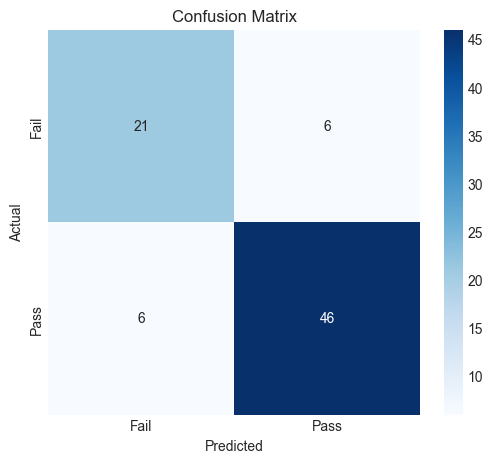

In [24]:
cm = confusion_matrix(y_clf_test, y_pred_clf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fail', 'Pass'], 
            yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 8. Training History & Learning Curves

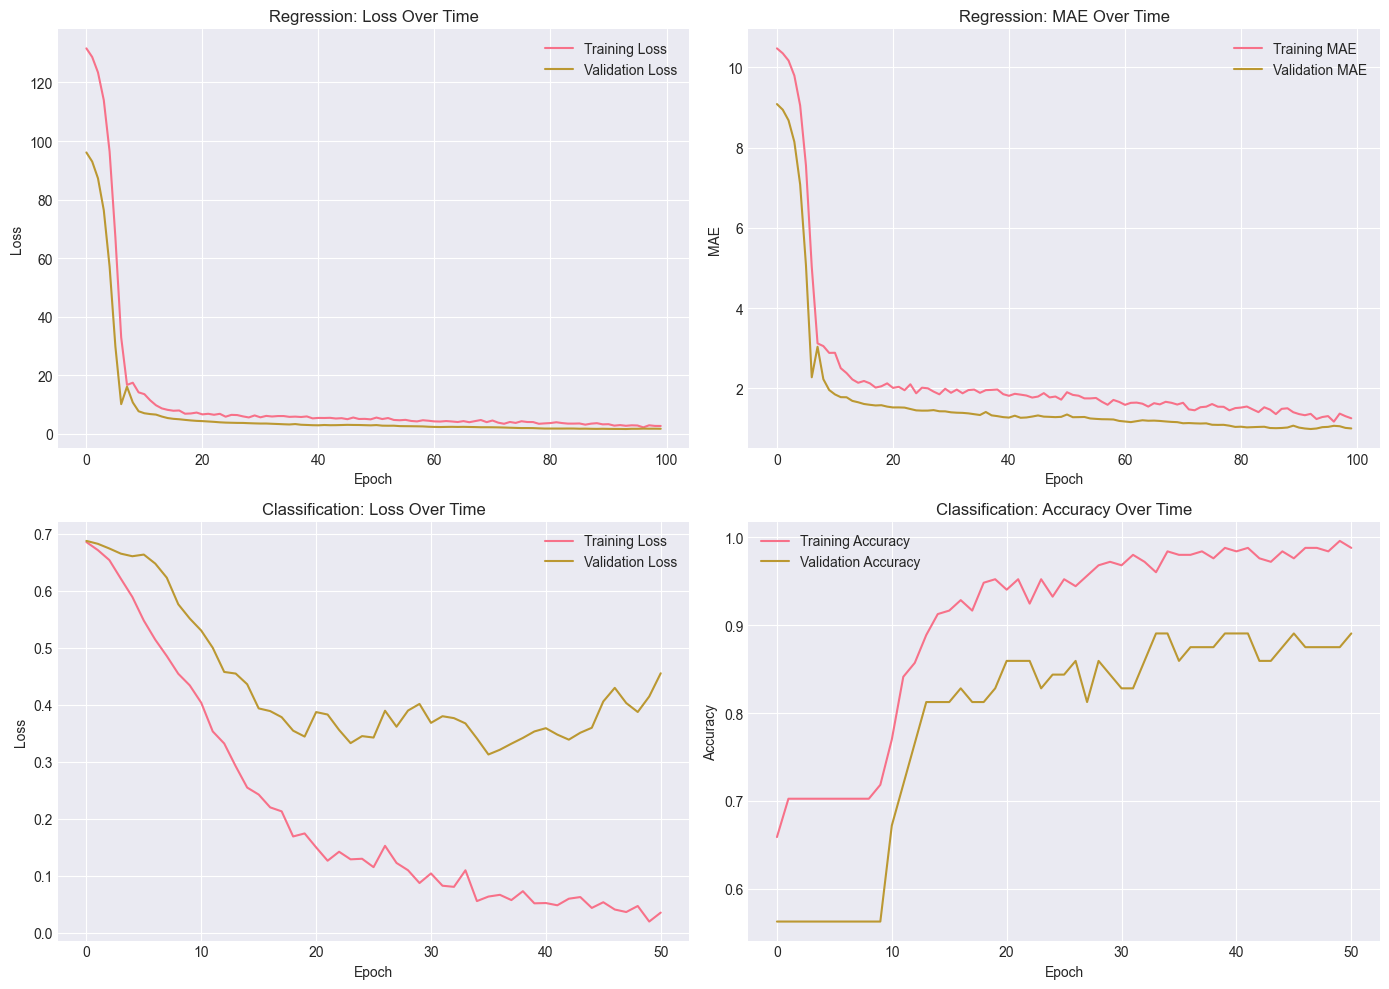

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(history_reg['train_loss'], label='Training Loss')
axes[0, 0].plot(history_reg['val_loss'], label='Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Regression: Loss Over Time')
axes[0, 0].legend()

axes[0, 1].plot(history_reg['train_metric'], label='Training MAE')
axes[0, 1].plot(history_reg['val_metric'], label='Validation MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Regression: MAE Over Time')
axes[0, 1].legend()

axes[1, 0].plot(history_clf['train_loss'], label='Training Loss')
axes[1, 0].plot(history_clf['val_loss'], label='Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Classification: Loss Over Time')
axes[1, 0].legend()

axes[1, 1].plot(history_clf['train_acc'], label='Training Accuracy')
axes[1, 1].plot(history_clf['val_acc'], label='Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Classification: Accuracy Over Time')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 9. What-If Demo - Predict for New Student

In [26]:
def predict_student(student_profile):
    student_df = pd.DataFrame([student_profile])
    student_transformed = preprocessor.transform(student_df)
    student_tensor = torch.FloatTensor(student_transformed).to(device)
    
    model_reg.eval()
    model_clf.eval()
    
    with torch.no_grad():
        predicted_grade = model_reg(student_tensor).cpu().numpy()[0][0]
        pass_probability = model_clf(student_tensor).cpu().numpy()[0][0]
    
    print("\n" + "="*50)
    print("STUDENT PERFORMANCE PREDICTION")
    print("="*50)
    print(f"\nPredicted Final Grade: {predicted_grade:.2f}/20")
    print(f"Pass Probability: {pass_probability*100:.1f}%")
    print(f"Predicted Outcome: {'PASS ✓' if pass_probability >= 0.5 else 'FAIL ✗'}")
    print("="*50)

In [27]:
example_student = {
    'school': 'GP', 'sex': 'F', 'age': 17, 'address': 'U',
    'famsize': 'GT3', 'Pstatus': 'T', 'Medu': 4, 'Fedu': 4,
    'Mjob': 'teacher', 'Fjob': 'other', 'reason': 'course',
    'guardian': 'mother', 'traveltime': 2, 'studytime': 3,
    'failures': 0, 'schoolsup': 'yes', 'famsup': 'yes',
    'paid': 'no', 'activities': 'yes', 'nursery': 'yes',
    'higher': 'yes', 'internet': 'yes', 'romantic': 'no',
    'famrel': 4, 'freetime': 3, 'goout': 2, 'Dalc': 1,
    'Walc': 1, 'health': 5, 'absences': 2, 'G1': 12, 'G2': 13
}

predict_student(example_student)


STUDENT PERFORMANCE PREDICTION

Predicted Final Grade: 12.70/20
Pass Probability: 100.0%
Predicted Outcome: PASS ✓


## Key Takeaways

**Why Neural Networks?**
- Can model complex non-linear relationships between features
- Automatically learn feature interactions
- Flexible architecture for different tasks

**Preprocessing:**
- StandardScaler: Normalizes numeric features (mean=0, std=1)
- OneHotEncoder: Converts categorical variables to binary vectors

**Regression vs Classification:**
- Regression: Predict continuous value (grade 0-20)
- Classification: Predict discrete class (pass/fail)

**PyTorch Model Components:**
- nn.Module: Base class for all neural network modules
- nn.Linear: Fully connected layer
- nn.ReLU: Activation function for hidden layers
- nn.Sigmoid: Activation for binary classification output
- nn.Dropout: Regularization to prevent overfitting
- DataLoader: Handles batching and shuffling
- Manual training loop: Forward pass → Loss → Backward pass → Optimizer step